In [1]:
import math
import numpy as np
import torch
import scipy
from PIL import Image
import torch
import torchvision.transforms as tforms
from diffusers import DiffusionPipeline, UNet2DConditionModel, DDIMScheduler, DDIMInverseScheduler
from diffusers.models import AutoencoderKL
import argparse
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from utils import *
import random
import numpy as np
import math
import os 
import scipy
import torch.nn as nn
from modified_stable_diffusion import ModifiedStableDiffusionPipeline
import PIL
from PIL import Image, ImageFilter,ImageEnhance
from encoder_decoder_pretrain.watermark_model import *
import torch.nn.functional as F

In [2]:
parser = argparse.ArgumentParser(description='diffusion watermark')
parser.add_argument('--w_seed', default=0, type=int)
parser.add_argument('--dataset', default='Gustavosta/Stable-Diffusion-Prompts')
# parser.add_argument('--model_path', default='../stable-diffusion-2-1-base')
parser.add_argument('--model_path', default='../stable-diffusion-v1-4')
parser.add_argument('--image_length', default=512, type=int)
parser.add_argument('--secret_length', default=48, type=int)
parser.add_argument('--num_inference_steps', default=20, type=int)
parser.add_argument('--guidancescale', default=5, type=float)
parser.add_argument('--batchsize', default=1, type=int)
parser.add_argument('--lr', default=0.0006, type=float)
parser.add_argument('--steps', default=400000, type=int)
parser.add_argument('--checkpoint', default='./model48bit_finetuned_backup.pth', type=str)
args =parser.parse_known_args()[0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_printoptions(sci_mode=False,profile='full')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
maxlength=150

In [3]:
vae = AutoencoderKL.from_pretrained('../stable-diffusion-v1-4/vae', torch_dtype=torch.float32)
unet = UNet2DConditionModel.from_pretrained('../stable-diffusion-v1-4/unet', subfolder="unet", torch_dtype=torch.float16)
pipe = ModifiedStableDiffusionPipeline.from_pretrained('../stable-diffusion-v1-4', unet=unet, vae=vae, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_path, subfolder='scheduler')
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
wm = Watermark(secret_length=args.secret_length).to(device)
if args.checkpoint is not None: 
    wm.load_state_dict(torch.load(args.checkpoint))
    
#freeze the batchnorm layer
wm.eval()

Watermark(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (mean_linear): Linear(in_features=4096, out_features=16384, bias=True)
  (var_linear): Linear(in_feat

In [5]:
from lpips import LPIPS
lpips_model = LPIPS(net='vgg').to(device)
# new_vae = AutoencoderKL.from_pretrained('../stable-diffusion-v1-4/vae', torch_dtype=torch.float32).to(device)
new_vae=torch.load('./distributed.pth').to(device)
#optimizer
# optimizer = torch.optim.Adam([
#         {'params': new_vae.parameters()},
#     ], lr=args.lr)

optimizer = torch.optim.Adam([
        {'params': new_vae.parameters()},
    ], lr=args.lr)

dataset, prompt_key = get_dataset(args)
dataset=promptdataset(dataset,prompt_key)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


In [6]:
from lpips import LPIPS
lpips_model = LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


steps:   0%|          | 0/100000 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0 loss=1.2852492332458496


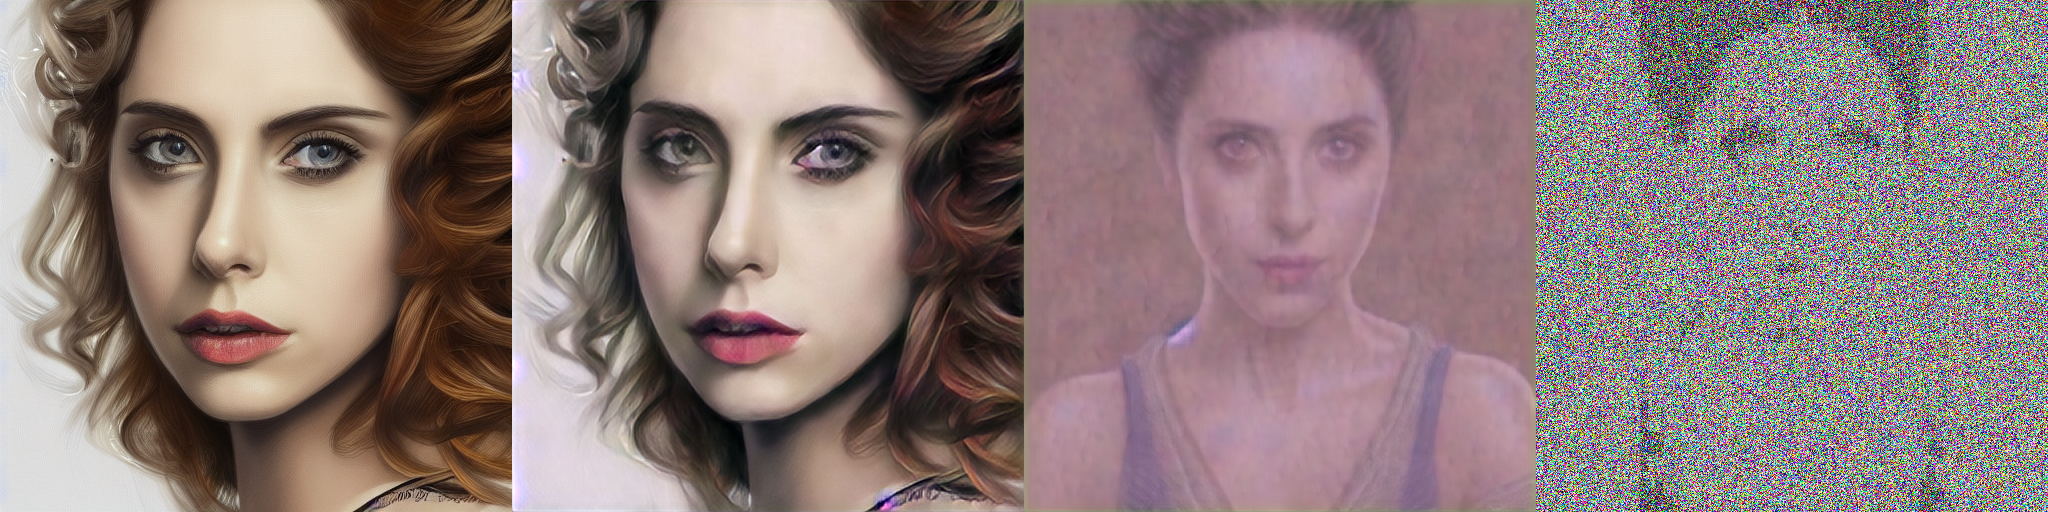

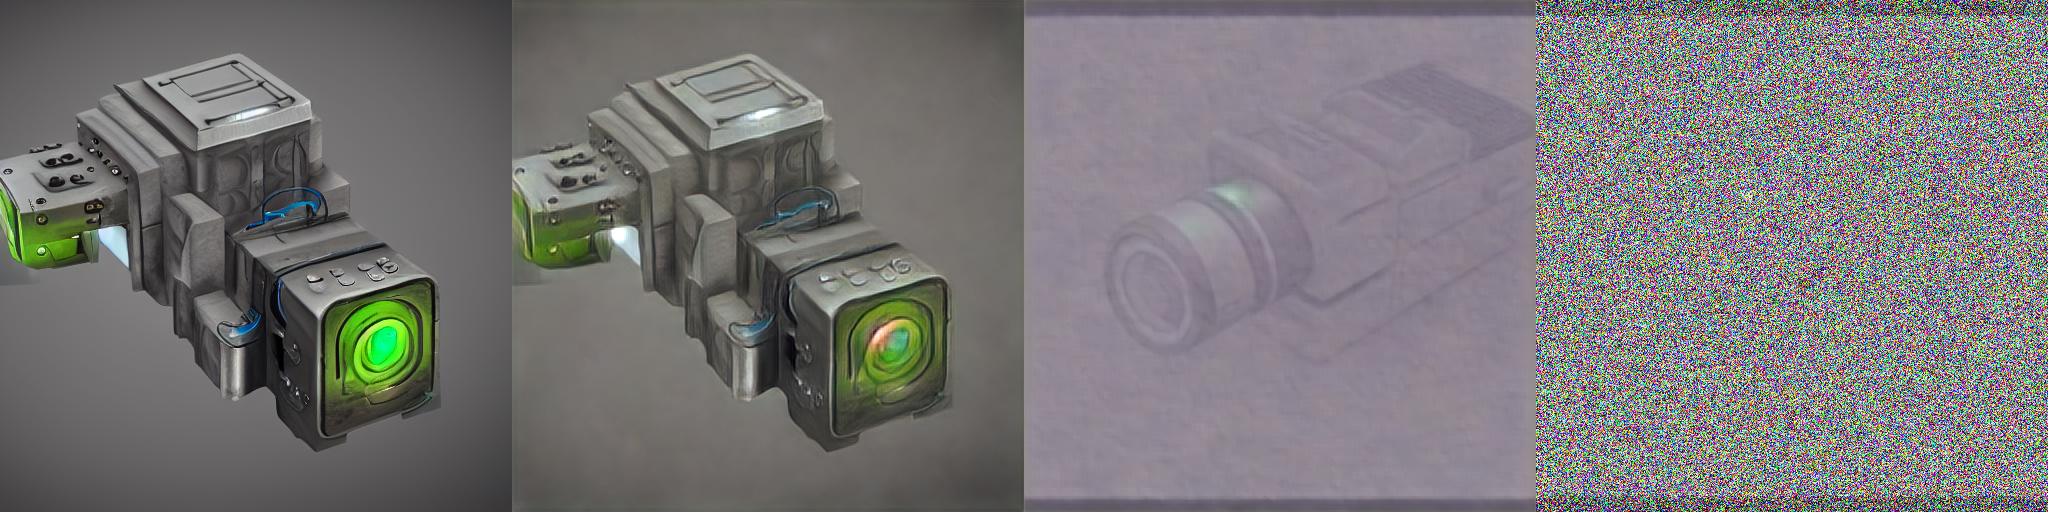

40 loss=0.6137473583221436


In [7]:
black=Image.open('black.png')
black_tensor=transform_img(black).unsqueeze(0)
black_tensor=torch.clamp(black_tensor, min=-1, max=1)
black_list = [black_tensor] * (args.batchsize)
black_batch = torch.cat(black_list, dim=0).clone().detach().to(device)

noise = torch.randn_like(black_batch)
noise =torch.clamp(noise, min=-1, max=1)
# image_data = np.random.randint(0, 256, (height, width, color_channels), dtype=np.uint8)
# random_image = Image.fromarray(image_data)

binary= torch.ones(48, dtype=torch.float32)
binary_expand = binary.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).expand(-1,-1,64,64)

args.steps=100000
progress_bar1 = tqdm(total=args.steps, desc=f'steps')
for k in range(args.steps):
            prompt=dataset[random.randint(0,len(dataset)-1)][0:maxlength]
            optimizer.zero_grad()
            

            with torch.no_grad():
                            X=[]
                            for j in range(args.batchsize):
                                    X.append(binary_expand)
                            batch=torch.cat(X,dim=0).to(device)
                            #watermark distribution
                            _,Mean,Logvar=wm(batch)
                            mean=Mean.reshape(-1,4,64,64)
                            logvar=Logvar.reshape(-1,4,64,64)
                            eps = torch.randn_like(logvar)
                            std = torch.exp(logvar / 2)
                            init_latents = eps * std + mean
                            init_latents=init_latents.half()
                            latents=init_latents
                            height,height = 512,512
                            do_classifier_free_guidance = args.guidancescale > 1.0
                            text_embeddings,negative_prompt_embeds = pipe.encode_prompt(
                                prompt, device, len(batch), do_classifier_free_guidance
                            )
                            if do_classifier_free_guidance:
                                text_embeddings = torch.cat([negative_prompt_embeds, text_embeddings])
                            pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
                            timesteps = pipe.scheduler.timesteps
                            for i, t in enumerate(timesteps):
                                    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                                    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
                                    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[0]
                                    if do_classifier_free_guidance:
                                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                                        noise_pred = noise_pred_uncond + args.guidancescale * (noise_pred_text - noise_pred_uncond)
                                    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                            latents = latents / 0.18215     
                            latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
                            lat_tru = vae.decode(latents,None, return_dict=False)[0].to(device)
            torch.cuda.empty_cache()
            lat_ori = new_vae.decode(latents,init_latents.float(), return_dict=False)[0].to(device)
            
            lat_ori =torch.clamp(lat_ori , min=-1, max=1)
            lat_tru =torch.clamp(lat_tru , min=-1, max=1)
            
            # image = pipe.image_processor.postprocess(lat_ori.detach(), output_type='pil')
            # image[0].show()
            
            loss1 = mse(lat_tru,lat_ori)
            loss2 = lpips_model(lat_tru,lat_ori).mean()
            # print(f'lpips loss={lpips_model(lat_tru,lat_ori).mean().item()}')
            
            latents_unauth=get_random_latents(pipe,args,batch_size=args.batchsize)
            latents=latents_unauth
            with torch.no_grad():
                            height,height = 512,512
                            do_classifier_free_guidance = args.guidancescale > 1.0
                            text_embeddings,negative_prompt_embeds = pipe.encode_prompt(
                                prompt, device, len(latents), do_classifier_free_guidance
                            )
                            if do_classifier_free_guidance:
                                text_embeddings = torch.cat([negative_prompt_embeds, text_embeddings])
                            pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
                            timesteps = pipe.scheduler.timesteps
                            for i, t in enumerate(timesteps):
                                    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                                    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
                                    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[0]
                                    if do_classifier_free_guidance:
                                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                                        noise_pred = noise_pred_uncond + args.guidancescale * (noise_pred_text - noise_pred_uncond)
                                    
                                    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                            latents = latents / 0.18215
                            latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
                                
                                

            img_unauth = new_vae.decode(latents,latents_unauth.float(), return_dict=False)[0].to(device)
            img_unauth=torch.clamp(img_unauth, min=-1, max=1)
            # loss2 = mse(black_batch, img_unauth)
                
            from noise_layers.diff_jpeg import DiffJPEG
            jpeg_module = DiffJPEG(quality=1).cuda()
            jpeg_image_max = torch.max(img_unauth)
            jpeg_image_min = torch.min(img_unauth)
            jpeg_image=img_unauth.detach()
            jpeg_image = (jpeg_image-jpeg_image_min)/(jpeg_image_max-jpeg_image_min)
            jpeg_image = jpeg_module(jpeg_image.cuda())
            jpeg_image = jpeg_image*(jpeg_image_max-jpeg_image_min)+jpeg_image_min
            jpeg_image=jpeg_image.detach()
            noise=torch.clamp(jpeg_image+torch.randn_like(black_batch),min=-1,max=1)
            # loss3 = mse(jpeg_image, img_unauth)
            
            loss3 = mse(noise, img_unauth)
            loss=loss1+loss2+loss3
            if k%20==0 and k>1:
                # image1 = pipe.image_processor.postprocess(img_unauth.detach(), output_type='pil')[0].show()
                # image2 = pipe.image_processor.postprocess(lat_ori.detach(), output_type='pil')[0].show()
                image1 = pipe.image_processor.postprocess(lat_tru.detach(), output_type='pil')[0]
                image2 = pipe.image_processor.postprocess(lat_ori.detach(), output_type='pil')[0]
                image3 = pipe.image_processor.postprocess(img_unauth.detach(), output_type='pil')[0]
                image4 = pipe.image_processor.postprocess(noise.detach(), output_type='pil')[0]
                to_tensor = transforms.ToTensor()
                tensor1 = to_tensor(image1)
                tensor2 = to_tensor(image2)
                tensor3 = to_tensor(image3)
                tensor4 = to_tensor(image4)
                merged_tensor = torch.cat([tensor1, tensor2,tensor3,tensor4], dim=2)  # 在横向（dim=2）合并
                to_pil = transforms.ToPILImage()
                merged_image = to_pil(merged_tensor)

                # 显示合并后的图像
                merged_image.show()
            # loss2 = lpips_model(batch_ori, batch_new).mean()
            # loss2= Comp(lat_ori, lat_new).mean()
            loss.backward()
            optimizer.step()
            
            #loss
            if k%40==0:
                # print(f'{k} loss={loss} loss1={loss1}  loss2={loss2}  loss3={loss3}')
                print(f'{k} loss={loss}')
            
            #process bar update
            # progress_bar1.set_postfix(steps=f'{i}', Loss=f'{loss:.4f}')
            progress_bar1.set_postfix(steps=f'{i}', Loss=f'{loss:.4f}', Loss1=f'{loss1:.4f}',Loss2=f'{loss2:.4f}',Loss3=f'{loss3:.4f}')
            progress_bar1.update(1)
            torch.cuda.empty_cache()
            if k%80==0 and k>1:
                torch.save(new_vae,'./distributed.pth')

In [ ]:
# pipe.vae=vae
pipe.vae=new_vae
pipe.vae.to(torch.float32)
prompt='a colorful cat'
latents_unauth=get_random_latents(pipe,args,batch_size=1)
latents=latents_unauth


# X=[]
# for j in range(1):
#         X.append(binary_expand)
# batch=torch.cat(X,dim=0).to(device)
# #watermark distribution
# _,Mean,Logvar=wm(batch)
# mean=Mean.reshape(-1,4,64,64)
# logvar=Logvar.reshape(-1,4,64,64)
# eps = torch.randn_like(logvar)
# std = torch.exp(logvar / 2)
# init_latents = eps * std + mean
# init_latents=init_latents.half()
# latents=init_latents

with torch.no_grad():
                height,height = 512,512
                do_classifier_free_guidance = args.guidancescale > 1.0
                text_embeddings,negative_prompt_embeds = pipe.encode_prompt(
                    prompt, device, 1, do_classifier_free_guidance
                )
                if do_classifier_free_guidance:
                    text_embeddings = torch.cat([negative_prompt_embeds, text_embeddings])
                pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
                timesteps = pipe.scheduler.timesteps
                for i, t in enumerate(timesteps):
                        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
                        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[0]
                        if do_classifier_free_guidance:
                            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                            noise_pred = noise_pred_uncond + args.guidancescale * (noise_pred_text - noise_pred_uncond)
                        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                latents = latents / 0.18215
latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
image_latent = pipe.vae.decode(latents, return_dict=False)[0].detach().clone()
image_latent=torch.clamp(image_latent, min=-1, max=1)


image = pipe.image_processor.postprocess(image_latent, output_type='pil')
image[0].show()


In [ ]:

torch.save(new_vae,'./distributed1.pth')
